# Cats don't chase Dogs

This experiment was presented at [QNLP 2019](file:///Users/alexis.toumi/WORK/discopy/docs/_build/html/talks/qnlp19.html). The original can by found on [DisCoPy repository](https://github.com/oxford-quantum-group/discopy/tree/main/docs/notebooks).

In [1]:
import math
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from random import random, uniform, seed
from discopy import Tensor
from discopy import Ty, Word, CircuitFunctor, qubit
from discopy.quantum import CX, H, Ket, Rx, Id, sqrt
from discopy.quantum.circuit import Functor
from discopy.rigid import Spider 

**1) First, we define the atomic pregroup types (typically ‘s’ and ‘n’).**

In [2]:
s, n = Ty('s'), Ty('n')

**2) We assign a number of qubits for each pregroup type. ‘s’ is set to 1 qubits, because the qubit for the sentence will be further inpoutted into logical connectors.**

In [3]:
ob = {s: 1, n: 1}

**3) Then we construct the finite vocabulary. For each word assign a pregroup type, using atomic pregroup types and invert types.**

In [4]:
dogs = Word('dogs', n)
chase = Word('chase', n.r @ s @ n.l)
cats =  Word('cats', n)
_do_not = Word("don't", n.r @ n)
purr = Word('purr', n.r @ s)

#number of dims
vocab = [dogs, chase, cats, _do_not, purr]
N = len(vocab)

**4) Every pregroup type will be mapped to a quantum circuit. We explicitely build the quantum circuits.**

Circuit for the intransitive ansatz state:

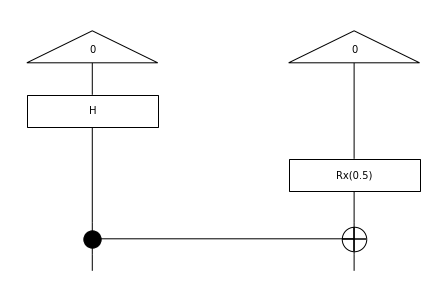

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[4.32978028e-17+0.j    , 0.00000000e+00-0.70710678j,
 0.00000000e+00-0.70710678j, 4.32978028e-17+0.j    ])


In [5]:
#"purr". Two outputs to offer opportunity of connecting to _and
def intransitive_ansatz(phase):
    return Ket(0, 0) >> H @ Rx(phase) >> CX

iv = intransitive_ansatz(0.5)
iv.draw(aspect='auto', draw_type_labels=False)
print(iv.eval())

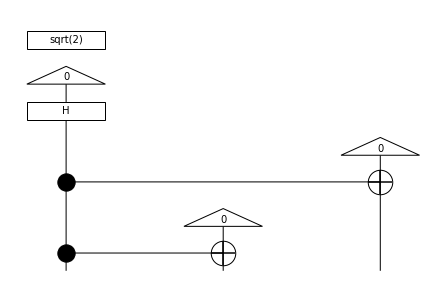

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])


In [6]:
#GHZ state. Output connects to subject, object and _and
def transitive_ansatz(phase):
    return Functor(ob=lambda o: o, ar=lambda a: a)(sqrt(2) @ Spider(0, 3, s, phase=phase))

tv = transitive_ansatz(0.5)
tv.draw(aspect='auto', draw_type_labels=False)
print(tv.eval())

Circuit for the transitive ansatz state:

**5) We explicit the mapping from each entry in the vocabulary to its corresponding quantum circuit.**

In [7]:
ar = lambda params: {
    dogs: Ket(0),
    chase: transitive_ansatz(params['chase']),
    cats: Ket(1),
    _do_not: intransitive_ansatz(params['_do_not']),
    purr: intransitive_ansatz(params['purr'])}

#number of params
number_parameters = 3

**6) Because the circuit is parameterized, we define a function which takes a set of parameters as inputs and outputs a functor from the grammar category to the category of quantum circuits.
The functor outputs the quantum circuit that encodes the syntactic tree of any given grammatical sentence it is inputted with.**

In [8]:
#F is a function which takes parameters as input and constructs a Functor
F = lambda params: CircuitFunctor(ob, ar({'chase': params[0], '_do_not': params[1], 'purr': params[2]}))

**7) We create another functor to evaluate the circuits.**

In [9]:
#We evaluate the circuit through applying another functor:
evaluate = lambda F, sentence: F(sentences2diagram[sentence]).measure()

**8) We instantiate the dataset: a random set of grammatical syntax trees generated by the CFG.We extract the labels from the csv giving the truth value of each sentence. 
We split the data in train and test set.**

dogs purr


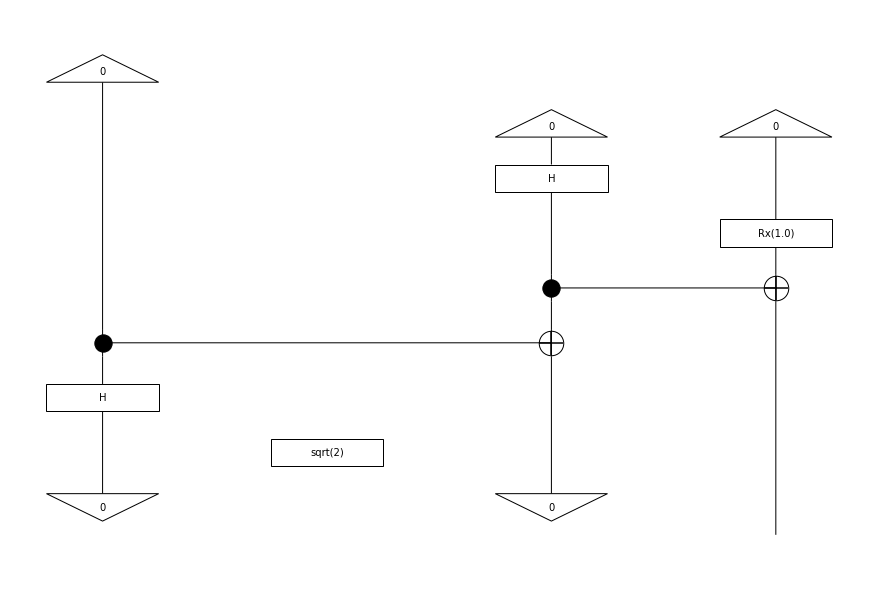


cats purr


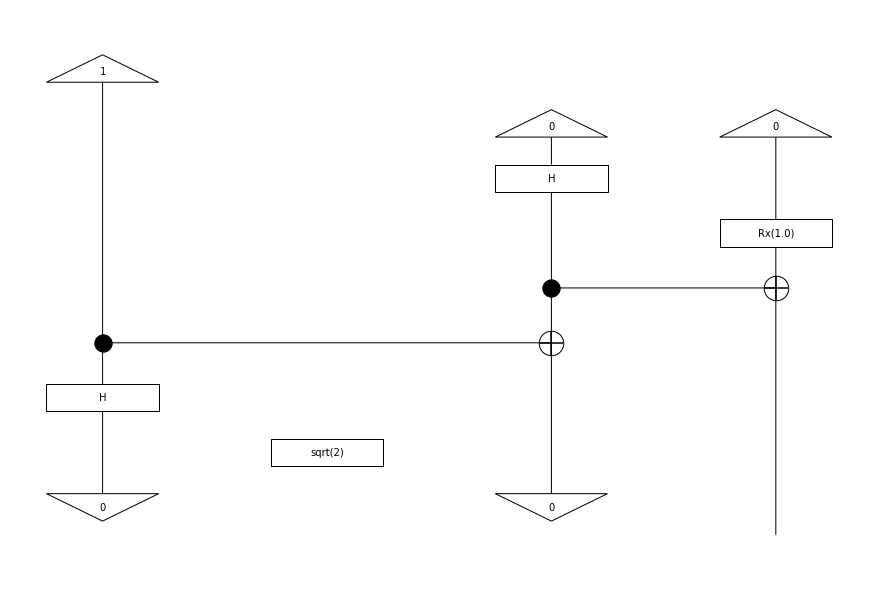


dogs chase dogs


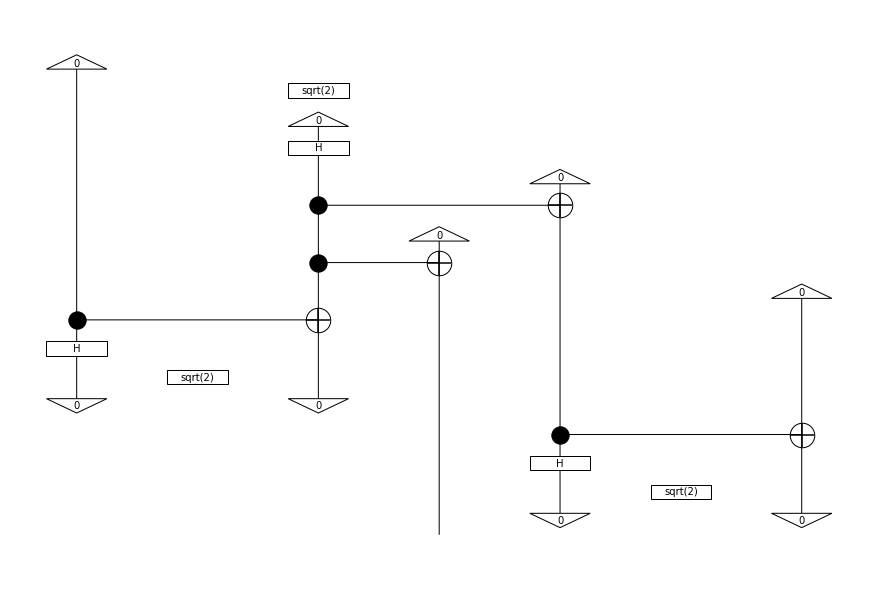


dogs chase cats


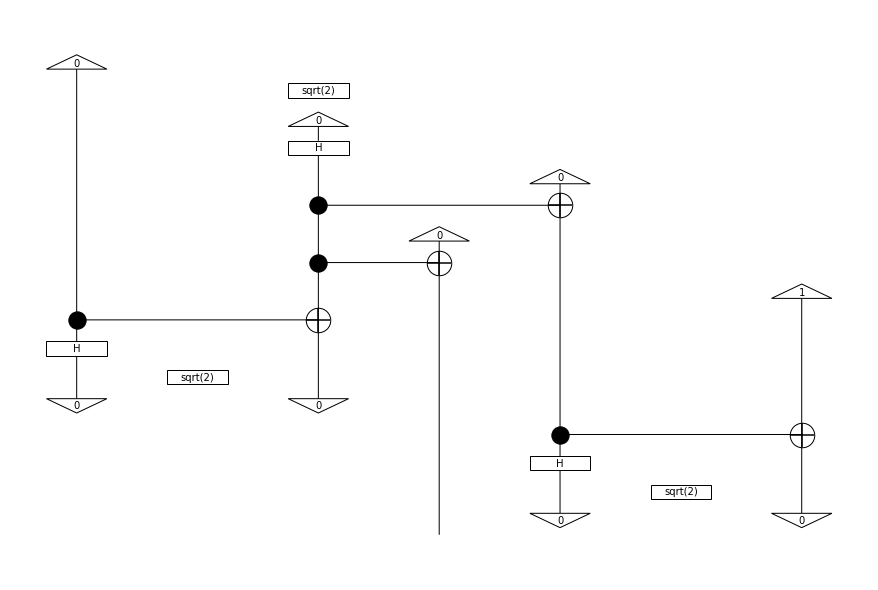


dogs don't purr


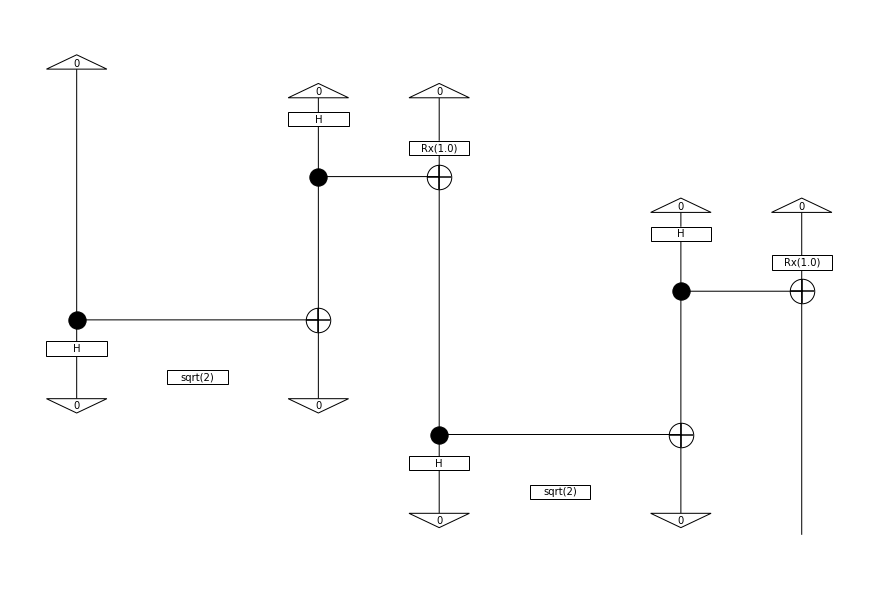


cats chase dogs


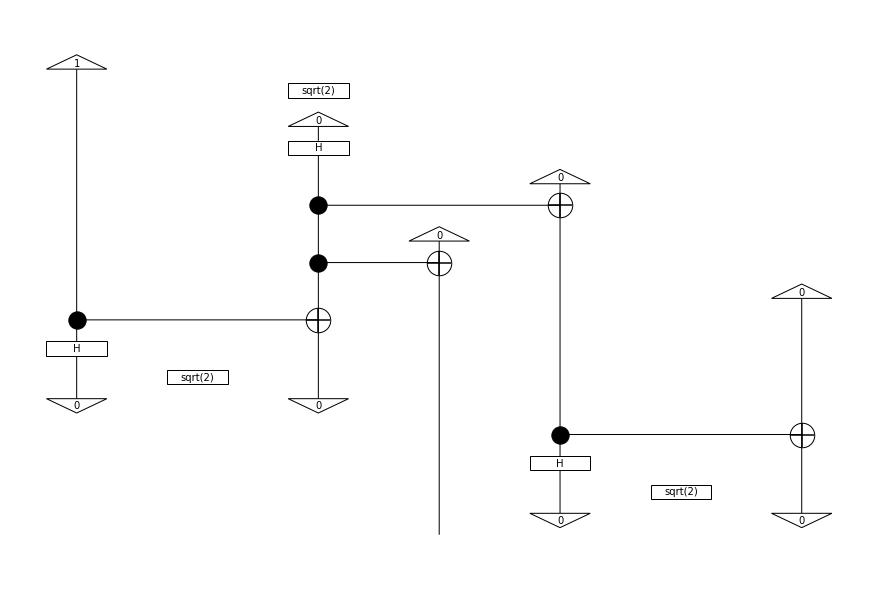


cats chase cats


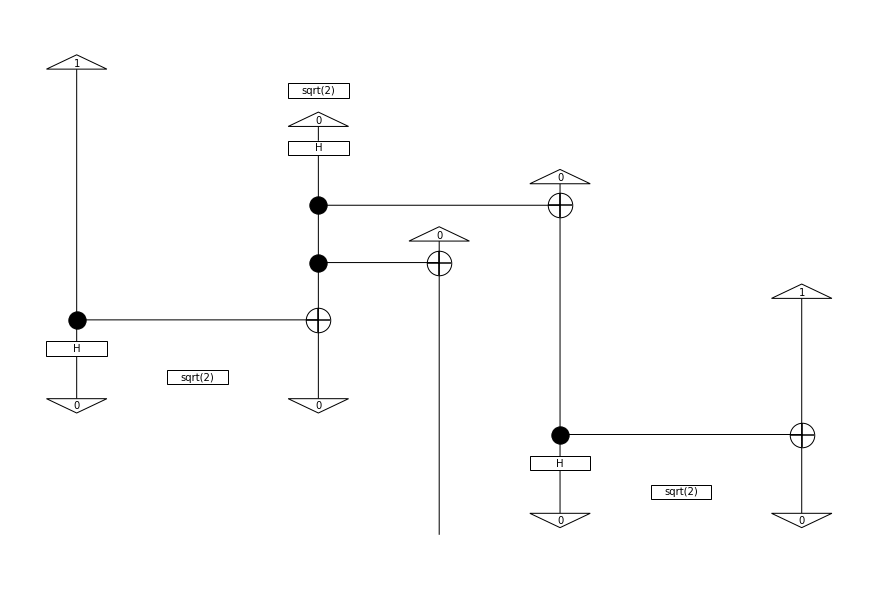


cats don't purr


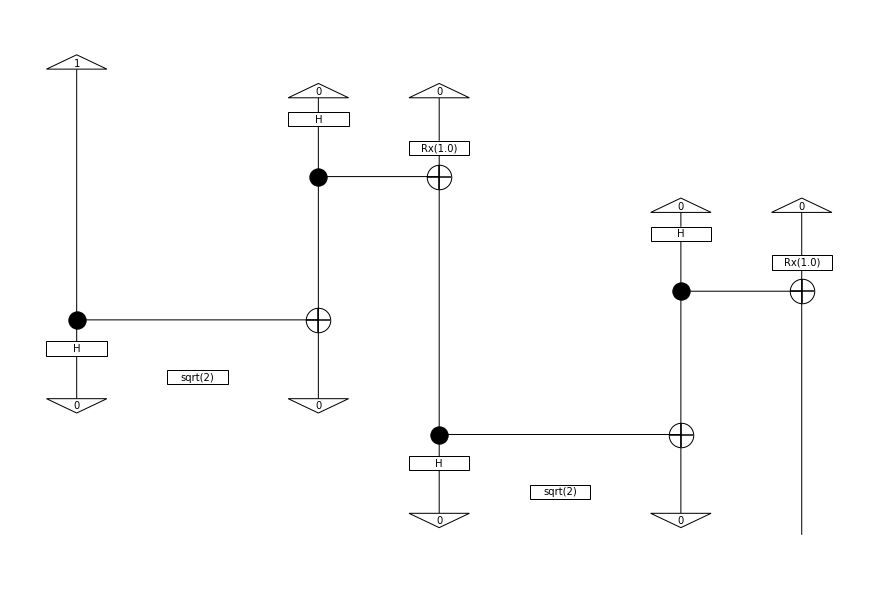


dogs don't chase dogs


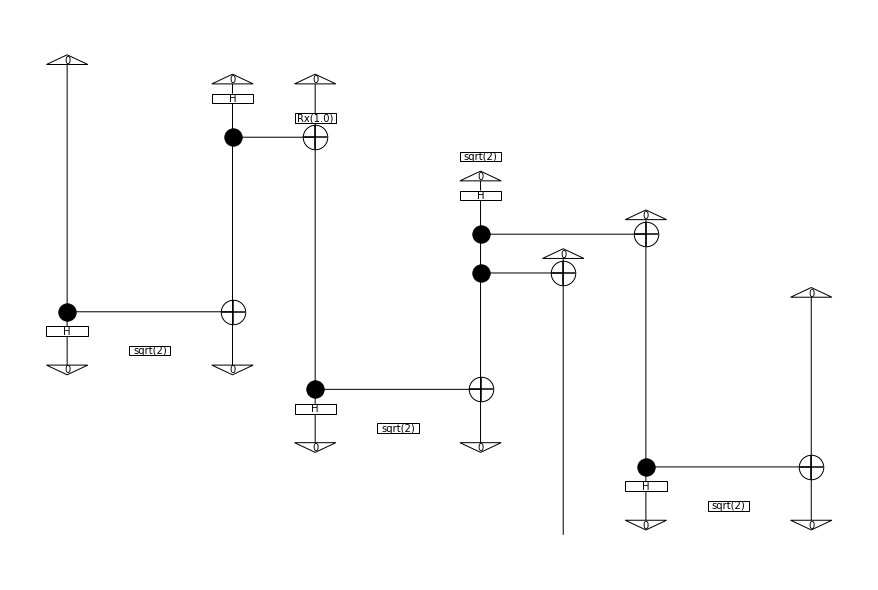


dogs don't chase cats


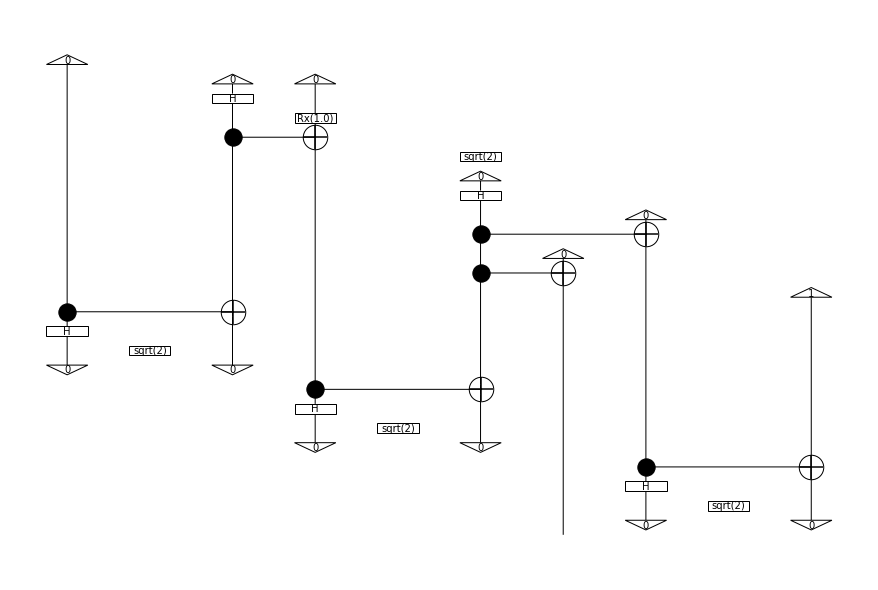


dogs don't don't purr


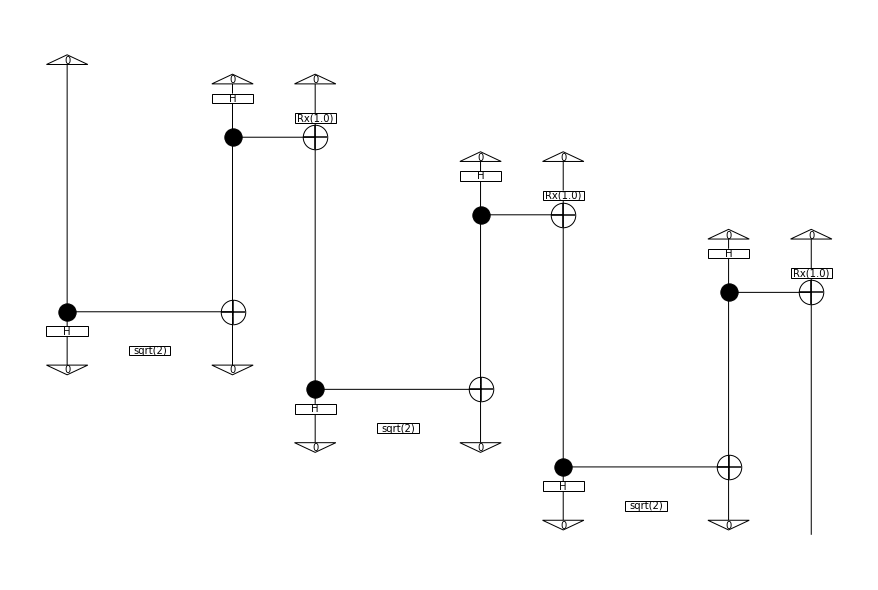


cats don't chase dogs


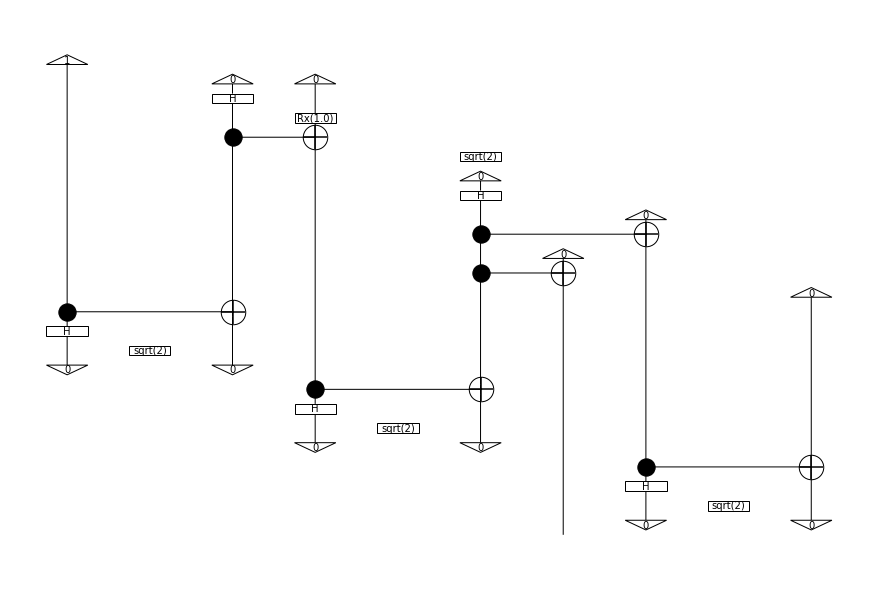


cats don't chase cats


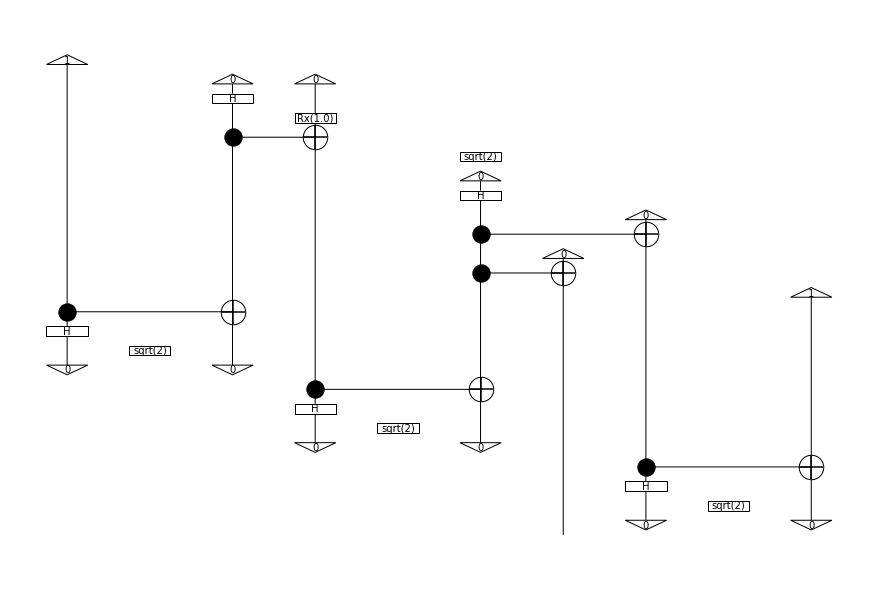


cats don't don't purr


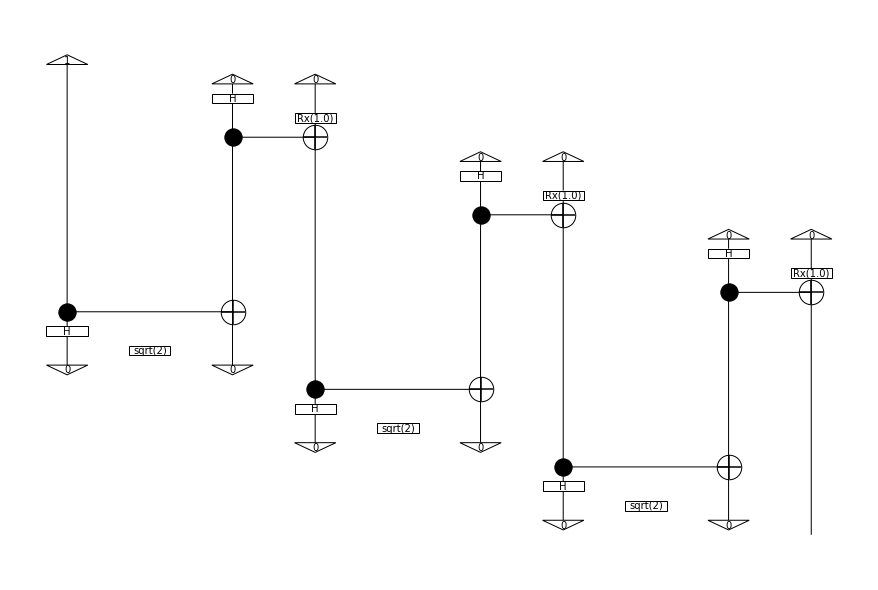


dogs don't don't chase dogs


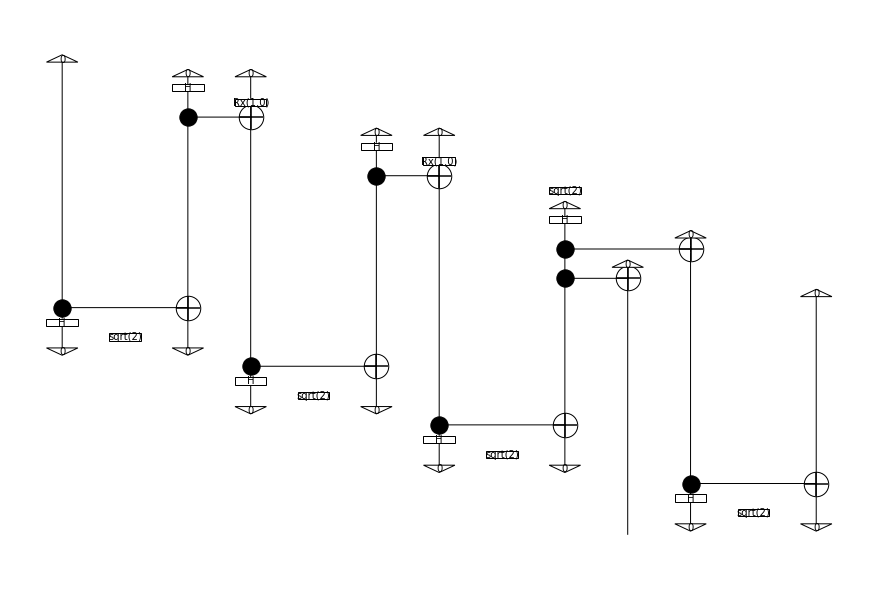


dogs don't don't chase cats


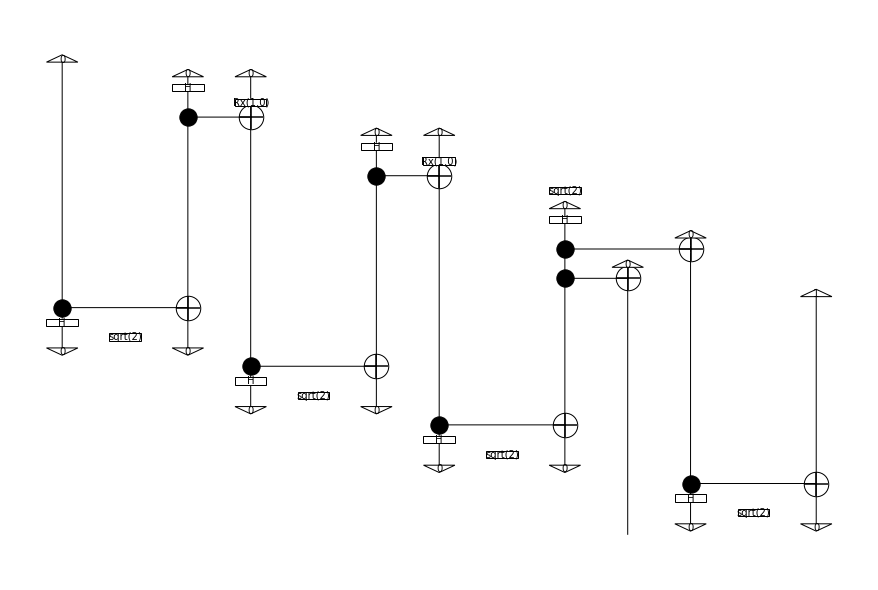


dogs don't don't don't purr


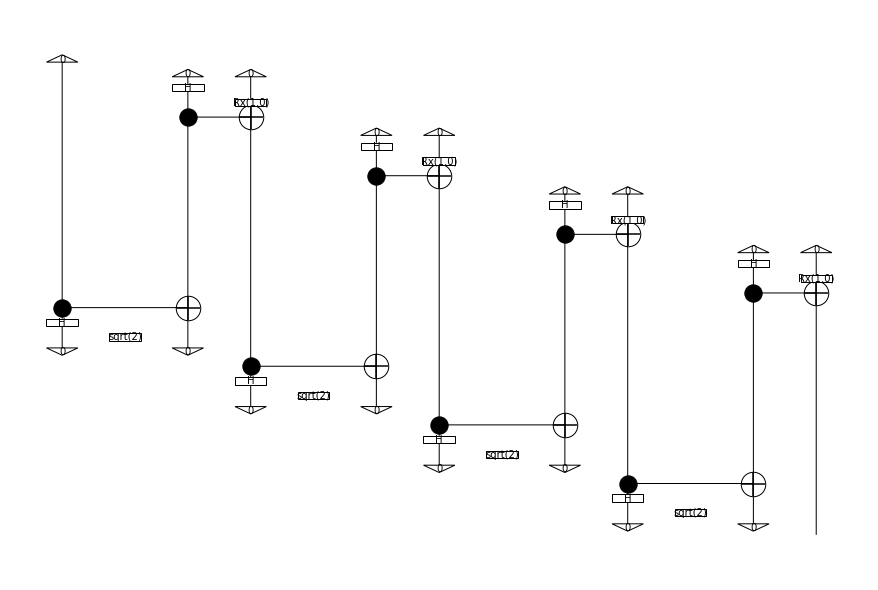


cats don't don't chase dogs


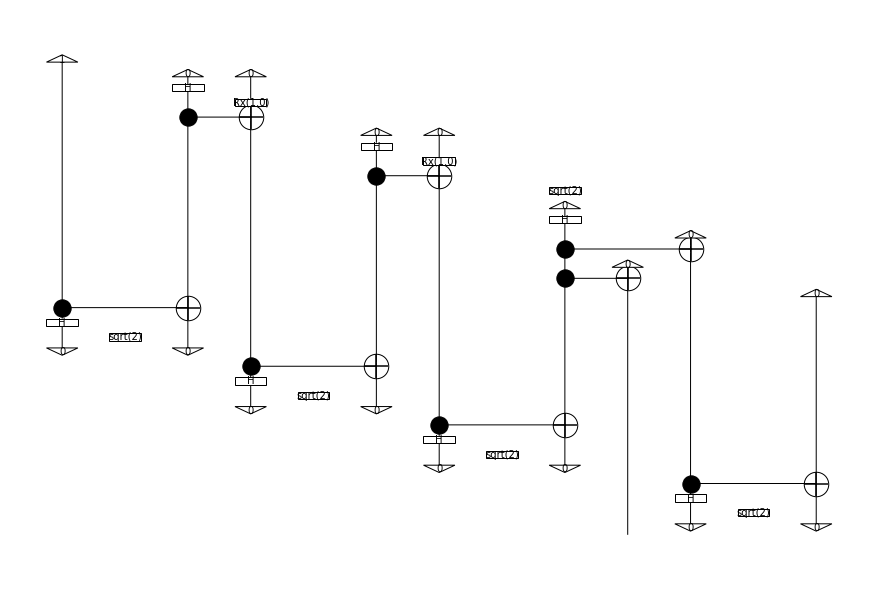


cats don't don't chase cats


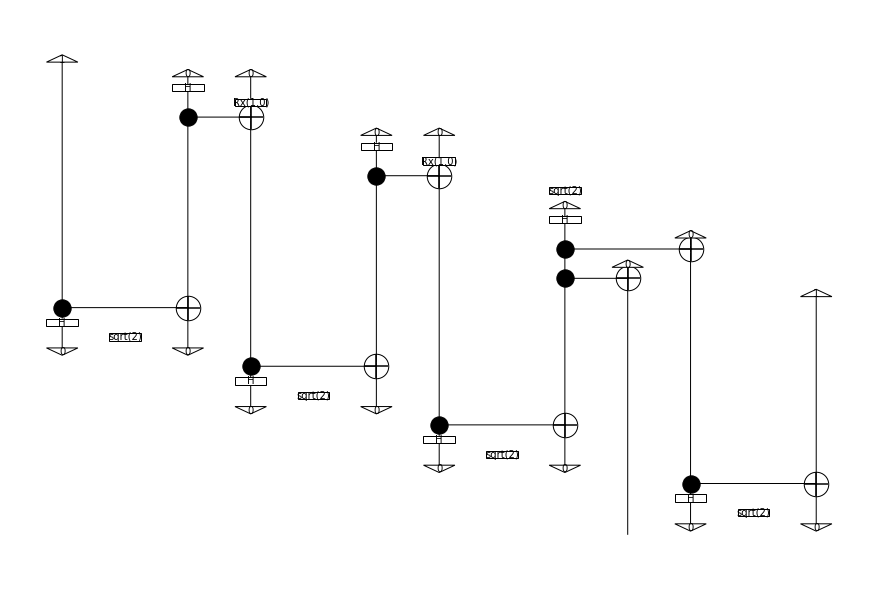


cats don't don't don't purr


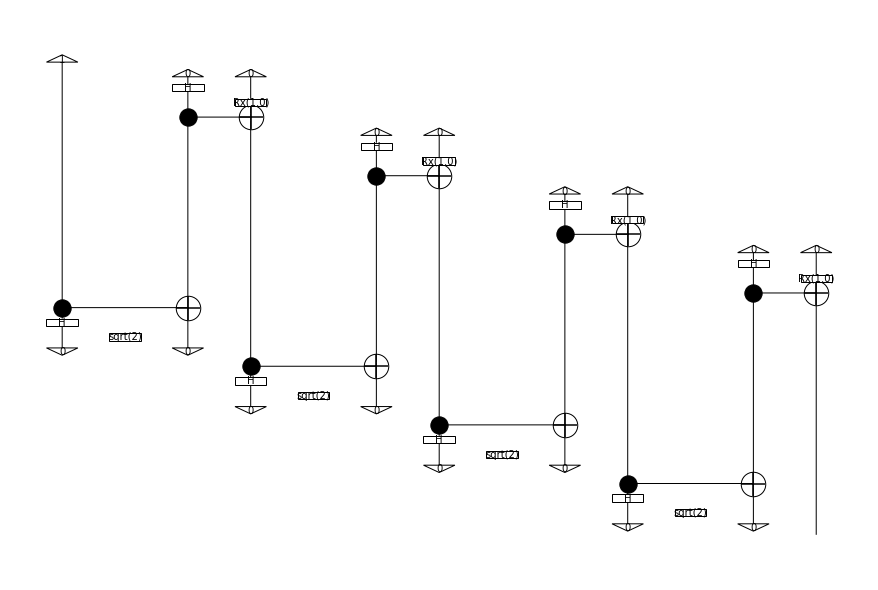

In [10]:
sentences = []
sentences2truth_values = {}
sentences2diagram = {}

csv_file = 'dataset.csv'
#csv_file = 'dataset_biaised.csv'
with open('datas/'+csv_file) as fp:
    for line in fp:
        line.strip("\n")
        sent_id, sentence, truth_value = line.split('\t')
        serialized_diagram = open('datas/serialized_sentences/'+sent_id, 'rb')
        diagram = pickle.loads(serialized_diagram.read())
        sentences.append(sentence)
        sentences2truth_values[sentence] = int(truth_value)
        sentences2diagram[sentence] = diagram
        #for visualization
        print(sentence)
        F(np.ones(N))(diagram).draw(figsize=(12, 8), aspect='auto', draw_type_labels=False, nodesize=1)
        print()

In [11]:
sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=0)

In [12]:
print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, truth_val in sentences2truth_values.items() if truth_val == 1)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, truth_val in sentences2truth_values.items() if truth_val == 0)))

True sentences:
cats purr
dogs chase dogs
dogs chase cats
dogs don't purr
cats chase cats
dogs don't don't purr
cats don't chase dogs
dogs don't don't chase dogs
dogs don't don't chase cats
dogs don't don't don't purr
cats don't don't chase cats

False sentences:
dogs purr
cats chase dogs
cats don't purr
dogs don't chase dogs
dogs don't chase cats
cats don't chase cats
cats don't don't purr
cats don't don't chase dogs
cats don't don't don't purr


**9) We use classical optimization techniques to choose the best parameters for the quantum circuits defined at step 4. Here, we only do a random search with the parameters space.**

In [13]:
def predict(params, sentence):
    output_qbit = evaluate(F(params), sentence)
    #print(output_qbit, end='\n')
    return 0 if output_qbit[0] > output_qbit[1] else 1

In [14]:
#Here we see that depending on the parameter, a given diagram will evaluate to True or False
test_sentence = "cats don't purr"

def find_specific_prediction(test_sentence, targeted_prediction):
    prediction = None
    while not prediction == targeted_prediction:
        test_params = np.array([uniform(-1, 1) for i in range(number_parameters)])
        prediction = predict(test_params, test_sentence)
    print("Random test_params: {},\t prediction: {}".format(test_params, prediction))

find_specific_prediction(test_sentence, 0)
find_specific_prediction(test_sentence, 1)

Random test_params: [-0.46530457  0.9254838   0.40661865],	 prediction: 0
Random test_params: [ 0.58454304  0.03272297 -0.79765622],	 prediction: 1


In [15]:
def predictions_score(params, dataset):
    count = 0
    for sentence in dataset:
        prediction = predict(params, sentence)
        actual_val = sentences2truth_values[sentence] 
        count += prediction == actual_val
    return int(count/len(dataset)*10000)/100

**Training and test set are split (50% - 50%), so we see the overall fitting score is 70%**

In [16]:
#found in https://towardsdatascience.com/the-best-way-to-pick-a-unit-vector-7bd0cc54f9b
#n being number of dimensions
def random_unit_vector(n):
    components = [np.random.normal() for i in range(number_parameters)]
    r = math.sqrt(sum(x*x for x in components))
    v = np.array([x/r for x in components])
    return v

In [20]:
np.random.seed(1)
seed(1)

#random descent
epochs = 3
iterations = 10

def run_epoch(iterations, print_updates=False):
    size_step = 0.20
    decay = 0.90
    test_params = np.array([uniform(-1, 1) for i in range(number_parameters)])

    best_score = 0
    #will contain test score for best params of epoch
    test_score = -1
    best_params = test_params

    for i in range(iterations):
        #calculate score
        score = predictions_score(test_params, sentence_train)

        #update best score
        if score > best_score:
            best_score = score
            best_params = test_params
            
            test_score = predictions_score(test_params, sentence_test)

            #print updated score
            if print_updates:
                print("Params at step {}: {},\nTraining score: {} %\nTesting score: {}%\n".format(i, test_params, score, test_score))

        #make a step
        step = random_unit_vector(number_parameters)*size_step
        size_step *= decay
        test_params = best_params + step

    return best_score, best_params, test_score

best_score = 0
best_params = None
for i in range(epochs):
    print('Epoch', i, '\n')
    print_updates = True if i == 0 else False
    score, test_params, test_score = run_epoch(iterations, print_updates)
    print("\n-> Best params found at this epoch: {},\nTraining score: {} %\nTesting score: {}%".format(test_params, score, test_score))
    print('\n---\n')
    if score > best_score:
        best_score = score
        best_params = test_params
    
print("\n\n---------\nBest params found: {},\nTraining score: {} %\nTesting score: {}%".format(best_params, best_score, predictions_score(best_params, sentence_test)))

Epoch 0 

Params at step 0: [-0.73127151  0.69486747  0.52754924],
Training score: 30.0 %
Testing score: 50.0%

Params at step 5: [-0.76539848  0.65421638  0.6475556 ],
Training score: 40.0 %
Testing score: 60.0%


-> Best params found at this epoch: [-0.76539848  0.65421638  0.6475556 ],
Training score: 40.0 %
Testing score: 60.0%

---

Epoch 1 


-> Best params found at this epoch: [-0.62127862 -0.08451364 -0.2315818 ],
Training score: 50.0 %
Testing score: 90.0%

---

Epoch 2 


-> Best params found at this epoch: [ 0.21023405  0.72977739 -0.83584575],
Training score: 40.0 %
Testing score: 80.0%

---



---------
Best params found: [-0.62127862 -0.08451364 -0.2315818 ],
Training score: 50.0 %
Testing score: 90.0%


**Training and test set are split (50% - 50%), so we see the overall best fitting score is 70%**